# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [4]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

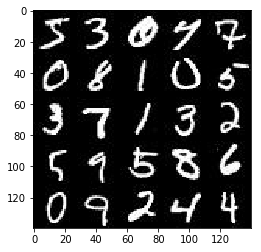

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

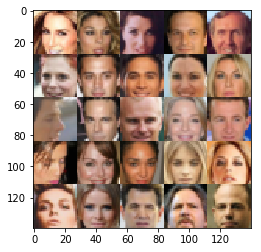

In [6]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [10]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='real_input')
    z_input = tf.placeholder(tf.float32, [None, z_dim], name='z_inputs')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "C:\\ProgramData\\Anaconda3\\Lib\\runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "C:\\ProgramData\\Anaconda3\\Lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "C:\\ProgramData\\Anaconda3\\lib\\site-packages\\ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "C:\\ProgramData\\Anaconda3\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "C:\\ProgramData\\Anaconda3\\lib\\site-packages\\ipykernel\\kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "C:\\ProgramData\\Anaconda3\\lib\\site-packages\\zmq\\eventloop\\ioloop.py", li

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [34]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        h1 = tf.layers.conv2d(images, 64, 4, strides=2, padding="same")
        h1 = tf.layers.batch_normalization(h1, training=True)
        h1 = tf.maximum(0.01 * h1, h1)
        
        h1 = tf.layers.conv2d(h1, 128, 4, strides=2, padding="same")
        h1 = tf.layers.batch_normalization(h1, training=True)
        h1 = tf.maximum(0.01 * h1, h1)

        h1 = tf.layers.conv2d(h1, 256, 4, strides=2, padding="same")
        h1 = tf.layers.batch_normalization(h1, training=True)
        h1 = tf.maximum(0.01 * h1, h1)
        
        h1 = tf.reshape(h1, (-1, 4*4*256))
        
        logits = tf.layers.dense(h1, 1, activation=None)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [35]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        h1 = tf.layers.dense(z, 4*4*512)
        
        h1 = tf.reshape(h1, (-1,4,4,512))
        h1 = tf.layers.batch_normalization(h1,training=is_train)
        h1 = tf.maximum(0.01 * h1, h1)

        h1 = tf.layers.conv2d_transpose(h1, 256, 4, strides=1, padding="valid")
        h1 = tf.layers.batch_normalization(h1,training=is_train)
        h1 = tf.maximum(0.01 * h1, h1)

        h1 = tf.layers.conv2d_transpose(h1, 128, 4, strides=2, padding="same")
        h1 = tf.layers.batch_normalization(h1,training=is_train)
        h1 = tf.maximum(0.01 * h1, h1)

        h1 = tf.layers.conv2d_transpose(h1, out_channel_dim, 4, strides=2, padding="same")

        logits = h1
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [36]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    gen_model = generator(input_z, out_channel_dim)
    disc_model_real, disc_logits_real = discriminator(input_real)
    disc_model_fake, disc_logits_fake = discriminator(gen_model, reuse=True)
    
    disc_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_real,
                                                                           labels=tf.ones_like(disc_model_real)*(1-0.1)))
    disc_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake,
                                                                           labels=tf.zeros_like(disc_model_fake)))
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake,
                                                                     labels=tf.ones_like(disc_model_fake)))
    
    disc_loss = disc_loss_real + disc_loss_fake
    return disc_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [37]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    gen_vars = [x for x in train_vars if x.name.startswith('generator')]
    disc_vars = [x for x in train_vars if x.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        disc_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=disc_vars)
        gen_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=gen_vars)
    return disc_train_opt, gen_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [38]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [41]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    real_input, z_input, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    discriminator_loss, generator_loss = model_loss(real_input, z_input, data_shape[-1])
    discriminator_train_opt, generator_train_opt = model_opt(discriminator_loss, generator_loss, learning_rate, beta1)
    j = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run(discriminator_train_opt, feed_dict={real_input: batch_images, z_input: batch_z, lr: learning_rate})
                sess.run(generator_train_opt, feed_dict={real_input: batch_images, z_input: batch_z, lr: learning_rate})
                
                j += 1
                if j % 10 == 0:
                    train_loss_discriminator = discriminator_loss.eval({z_input: batch_z, real_input: batch_images})
                    train_loss_generator = generator_loss.eval({z_input: batch_z})
                    print('Epoch %d/%d Discriminator loss %.4f Generator loss %.4f' % (epoch_i+1, epoch_count, train_loss_discriminator, train_loss_generator ))
                
                if j % 100 == 0:
                    show_generator_output(sess, 50, z_input, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 Discriminator loss 1.4349 Generator loss 0.5135
Epoch 1/2 Discriminator loss 0.7697 Generator loss 1.5585
Epoch 1/2 Discriminator loss 0.8050 Generator loss 1.8511
Epoch 1/2 Discriminator loss 1.1809 Generator loss 2.4600
Epoch 1/2 Discriminator loss 0.8675 Generator loss 2.3116
Epoch 1/2 Discriminator loss 0.6375 Generator loss 2.2492
Epoch 1/2 Discriminator loss 0.5963 Generator loss 2.3555
Epoch 1/2 Discriminator loss 0.5426 Generator loss 2.4702
Epoch 1/2 Discriminator loss 0.5901 Generator loss 1.8722
Epoch 1/2 Discriminator loss 0.8812 Generator loss 0.9794


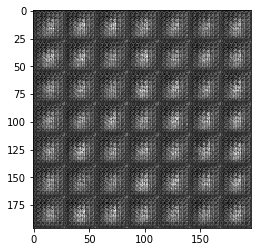

Epoch 1/2 Discriminator loss 0.5628 Generator loss 1.9074
Epoch 1/2 Discriminator loss 0.4963 Generator loss 2.3696
Epoch 1/2 Discriminator loss 0.4485 Generator loss 2.7118
Epoch 1/2 Discriminator loss 0.4978 Generator loss 2.5650
Epoch 1/2 Discriminator loss 0.4325 Generator loss 2.9436
Epoch 1/2 Discriminator loss 0.4219 Generator loss 3.0853
Epoch 1/2 Discriminator loss 0.4284 Generator loss 3.0717
Epoch 1/2 Discriminator loss 0.4330 Generator loss 2.9903
Epoch 1/2 Discriminator loss 0.4318 Generator loss 3.2538
Epoch 1/2 Discriminator loss 0.4593 Generator loss 2.6450


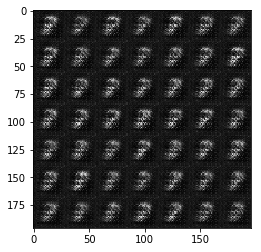

Epoch 1/2 Discriminator loss 0.5631 Generator loss 2.0056
Epoch 1/2 Discriminator loss 0.5206 Generator loss 2.0927
Epoch 1/2 Discriminator loss 0.4200 Generator loss 3.3006
Epoch 1/2 Discriminator loss 0.5255 Generator loss 3.7130
Epoch 1/2 Discriminator loss 0.4875 Generator loss 2.4260
Epoch 1/2 Discriminator loss 1.3735 Generator loss 0.6842
Epoch 1/2 Discriminator loss 0.7360 Generator loss 1.4463
Epoch 1/2 Discriminator loss 0.5974 Generator loss 1.8933
Epoch 1/2 Discriminator loss 0.7008 Generator loss 3.3047
Epoch 1/2 Discriminator loss 0.5303 Generator loss 2.3808


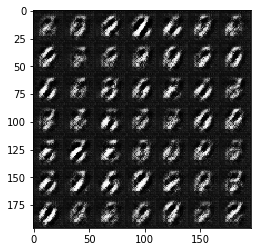

Epoch 1/2 Discriminator loss 0.5368 Generator loss 2.4051
Epoch 1/2 Discriminator loss 0.6286 Generator loss 1.9763
Epoch 1/2 Discriminator loss 0.7729 Generator loss 3.8124
Epoch 1/2 Discriminator loss 0.6526 Generator loss 2.8961
Epoch 1/2 Discriminator loss 0.7289 Generator loss 1.4154
Epoch 1/2 Discriminator loss 0.7331 Generator loss 2.8454
Epoch 1/2 Discriminator loss 0.7472 Generator loss 2.3946
Epoch 1/2 Discriminator loss 0.9623 Generator loss 3.1679
Epoch 1/2 Discriminator loss 0.7631 Generator loss 2.5101
Epoch 1/2 Discriminator loss 0.8924 Generator loss 1.0129


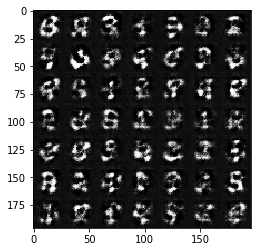

Epoch 1/2 Discriminator loss 0.9412 Generator loss 0.9469
Epoch 1/2 Discriminator loss 0.6499 Generator loss 1.8226
Epoch 1/2 Discriminator loss 0.8515 Generator loss 3.3596
Epoch 1/2 Discriminator loss 0.7574 Generator loss 1.7351
Epoch 1/2 Discriminator loss 0.8485 Generator loss 2.7773
Epoch 1/2 Discriminator loss 1.1490 Generator loss 3.4985
Epoch 1/2 Discriminator loss 0.6796 Generator loss 1.8104
Epoch 1/2 Discriminator loss 0.7144 Generator loss 1.3799
Epoch 1/2 Discriminator loss 0.9750 Generator loss 2.8124
Epoch 1/2 Discriminator loss 0.9222 Generator loss 2.6837


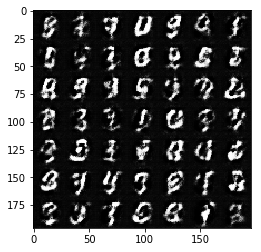

Epoch 1/2 Discriminator loss 0.9082 Generator loss 2.8049
Epoch 1/2 Discriminator loss 0.6821 Generator loss 1.5045
Epoch 1/2 Discriminator loss 0.7960 Generator loss 1.2041
Epoch 1/2 Discriminator loss 0.8777 Generator loss 2.5585
Epoch 1/2 Discriminator loss 1.1470 Generator loss 3.2608
Epoch 1/2 Discriminator loss 0.8572 Generator loss 2.1658
Epoch 1/2 Discriminator loss 0.7808 Generator loss 2.0152
Epoch 1/2 Discriminator loss 0.7740 Generator loss 1.9251
Epoch 1/2 Discriminator loss 0.9737 Generator loss 0.8661
Epoch 1/2 Discriminator loss 0.7031 Generator loss 1.5039


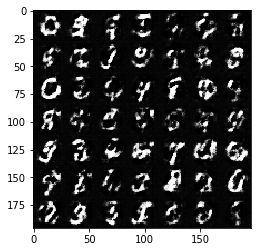

Epoch 2/2 Discriminator loss 0.8085 Generator loss 2.2146
Epoch 2/2 Discriminator loss 0.7295 Generator loss 1.6265
Epoch 2/2 Discriminator loss 0.9837 Generator loss 2.7741
Epoch 2/2 Discriminator loss 0.8141 Generator loss 1.9948
Epoch 2/2 Discriminator loss 0.6946 Generator loss 1.7651
Epoch 2/2 Discriminator loss 0.7571 Generator loss 1.6385
Epoch 2/2 Discriminator loss 1.1966 Generator loss 0.6587
Epoch 2/2 Discriminator loss 1.0169 Generator loss 0.8100
Epoch 2/2 Discriminator loss 0.7255 Generator loss 1.3616
Epoch 2/2 Discriminator loss 0.9793 Generator loss 0.8471


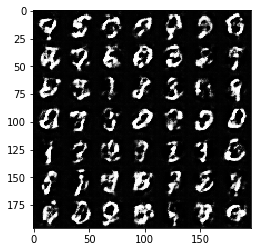

Epoch 2/2 Discriminator loss 1.1143 Generator loss 0.7104
Epoch 2/2 Discriminator loss 1.2441 Generator loss 0.6215
Epoch 2/2 Discriminator loss 0.6788 Generator loss 1.6191
Epoch 2/2 Discriminator loss 0.9947 Generator loss 2.4749
Epoch 2/2 Discriminator loss 0.7360 Generator loss 1.6876
Epoch 2/2 Discriminator loss 0.8870 Generator loss 1.0250
Epoch 2/2 Discriminator loss 0.9075 Generator loss 0.9758
Epoch 2/2 Discriminator loss 1.2427 Generator loss 2.9964
Epoch 2/2 Discriminator loss 0.7567 Generator loss 1.7416
Epoch 2/2 Discriminator loss 1.2411 Generator loss 0.6119


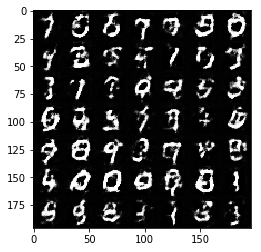

Epoch 2/2 Discriminator loss 0.7122 Generator loss 1.3694
Epoch 2/2 Discriminator loss 0.8033 Generator loss 1.7509
Epoch 2/2 Discriminator loss 0.8664 Generator loss 1.0619
Epoch 2/2 Discriminator loss 0.9139 Generator loss 0.9938
Epoch 2/2 Discriminator loss 1.7134 Generator loss 3.5209
Epoch 2/2 Discriminator loss 0.7459 Generator loss 1.6595
Epoch 2/2 Discriminator loss 0.9587 Generator loss 0.9257
Epoch 2/2 Discriminator loss 0.7875 Generator loss 1.2717
Epoch 2/2 Discriminator loss 0.8117 Generator loss 1.7945
Epoch 2/2 Discriminator loss 1.2873 Generator loss 2.6316


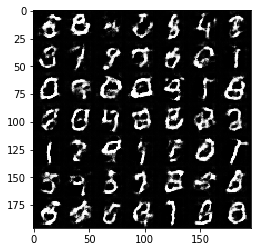

Epoch 2/2 Discriminator loss 0.8136 Generator loss 1.5793
Epoch 2/2 Discriminator loss 0.8600 Generator loss 1.2613
Epoch 2/2 Discriminator loss 1.3572 Generator loss 0.5337
Epoch 2/2 Discriminator loss 0.8646 Generator loss 1.5354
Epoch 2/2 Discriminator loss 0.8181 Generator loss 1.2506
Epoch 2/2 Discriminator loss 0.8280 Generator loss 2.0607
Epoch 2/2 Discriminator loss 0.9298 Generator loss 1.8764
Epoch 2/2 Discriminator loss 0.7791 Generator loss 1.4425
Epoch 2/2 Discriminator loss 0.9755 Generator loss 1.9943
Epoch 2/2 Discriminator loss 1.2757 Generator loss 0.5860


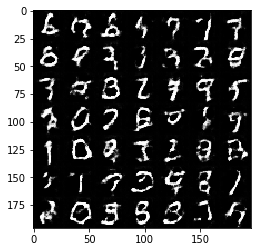

Epoch 2/2 Discriminator loss 0.9919 Generator loss 0.8789
Epoch 2/2 Discriminator loss 0.9499 Generator loss 0.9010
Epoch 2/2 Discriminator loss 0.8393 Generator loss 1.7414
Epoch 2/2 Discriminator loss 0.9057 Generator loss 1.4080
Epoch 2/2 Discriminator loss 1.0150 Generator loss 1.8193
Epoch 2/2 Discriminator loss 0.9340 Generator loss 2.1597
Epoch 2/2 Discriminator loss 0.9983 Generator loss 0.8721
Epoch 2/2 Discriminator loss 0.8733 Generator loss 1.0774
Epoch 2/2 Discriminator loss 0.9268 Generator loss 1.6253
Epoch 2/2 Discriminator loss 0.9829 Generator loss 1.9379


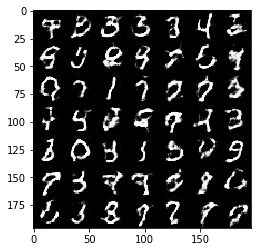

Epoch 2/2 Discriminator loss 1.3347 Generator loss 2.2757
Epoch 2/2 Discriminator loss 0.9388 Generator loss 0.9821
Epoch 2/2 Discriminator loss 0.9215 Generator loss 1.0019
Epoch 2/2 Discriminator loss 0.8449 Generator loss 1.3422
Epoch 2/2 Discriminator loss 1.3326 Generator loss 3.2065
Epoch 2/2 Discriminator loss 0.9707 Generator loss 1.5823
Epoch 2/2 Discriminator loss 0.9756 Generator loss 1.1250
Epoch 2/2 Discriminator loss 0.9100 Generator loss 1.2550
Epoch 2/2 Discriminator loss 1.0946 Generator loss 0.7423
Epoch 2/2 Discriminator loss 0.7510 Generator loss 1.3854


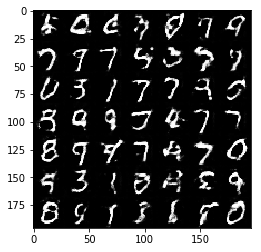

In [42]:
batch_size = 100
z_dim = 100
learning_rate = 0.0001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 Discriminator loss 0.9160 Generator loss 14.2238
Epoch 1/1 Discriminator loss 2.9244 Generator loss 0.1052
Epoch 1/1 Discriminator loss 0.5597 Generator loss 9.3681
Epoch 1/1 Discriminator loss 0.6501 Generator loss 10.6877
Epoch 1/1 Discriminator loss 1.3221 Generator loss 0.5634
Epoch 1/1 Discriminator loss 1.1344 Generator loss 6.3848
Epoch 1/1 Discriminator loss 1.7494 Generator loss 0.4304
Epoch 1/1 Discriminator loss 1.7168 Generator loss 0.4319
Epoch 1/1 Discriminator loss 2.1591 Generator loss 0.2322
Epoch 1/1 Discriminator loss 1.6496 Generator loss 0.4221


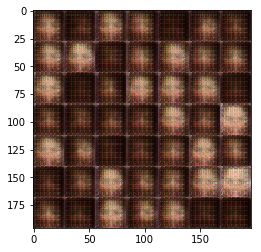

Epoch 1/1 Discriminator loss 1.4062 Generator loss 0.5562
Epoch 1/1 Discriminator loss 1.3579 Generator loss 0.5771
Epoch 1/1 Discriminator loss 1.8729 Generator loss 0.3176
Epoch 1/1 Discriminator loss 1.6404 Generator loss 0.4291
Epoch 1/1 Discriminator loss 1.5257 Generator loss 0.5102
Epoch 1/1 Discriminator loss 1.4453 Generator loss 0.5561
Epoch 1/1 Discriminator loss 1.5807 Generator loss 0.4497
Epoch 1/1 Discriminator loss 1.6406 Generator loss 0.4122
Epoch 1/1 Discriminator loss 1.6199 Generator loss 0.4181
Epoch 1/1 Discriminator loss 1.6815 Generator loss 0.3596


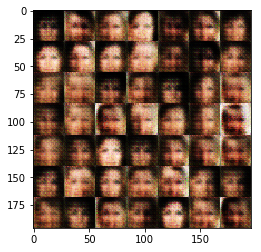

Epoch 1/1 Discriminator loss 1.4436 Generator loss 0.5065
Epoch 1/1 Discriminator loss 1.7791 Generator loss 0.3346
Epoch 1/1 Discriminator loss 1.7811 Generator loss 0.3174
Epoch 1/1 Discriminator loss 1.5631 Generator loss 0.4292
Epoch 1/1 Discriminator loss 1.6074 Generator loss 0.3904
Epoch 1/1 Discriminator loss 1.5330 Generator loss 0.4535
Epoch 1/1 Discriminator loss 1.5158 Generator loss 0.4636
Epoch 1/1 Discriminator loss 1.5418 Generator loss 0.4342
Epoch 1/1 Discriminator loss 1.5035 Generator loss 0.4497
Epoch 1/1 Discriminator loss 1.5563 Generator loss 0.4508


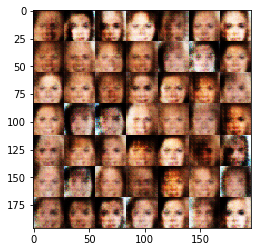

Epoch 1/1 Discriminator loss 1.4098 Generator loss 0.5377
Epoch 1/1 Discriminator loss 1.4727 Generator loss 0.4932
Epoch 1/1 Discriminator loss 1.5078 Generator loss 0.4836
Epoch 1/1 Discriminator loss 1.4930 Generator loss 0.4876
Epoch 1/1 Discriminator loss 1.6144 Generator loss 0.4119
Epoch 1/1 Discriminator loss 1.4176 Generator loss 0.6725
Epoch 1/1 Discriminator loss 1.5080 Generator loss 0.4669
Epoch 1/1 Discriminator loss 1.6444 Generator loss 0.4206
Epoch 1/1 Discriminator loss 1.4076 Generator loss 0.5854
Epoch 1/1 Discriminator loss 1.3896 Generator loss 0.5737


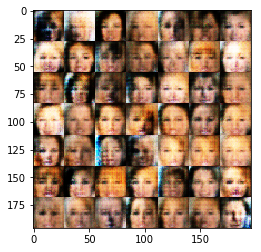

Epoch 1/1 Discriminator loss 1.5427 Generator loss 0.4438
Epoch 1/1 Discriminator loss 1.4060 Generator loss 0.6588
Epoch 1/1 Discriminator loss 1.6096 Generator loss 1.4870
Epoch 1/1 Discriminator loss 1.2721 Generator loss 0.8368
Epoch 1/1 Discriminator loss 1.6993 Generator loss 1.5042
Epoch 1/1 Discriminator loss 1.4959 Generator loss 1.0266
Epoch 1/1 Discriminator loss 1.3201 Generator loss 1.1169
Epoch 1/1 Discriminator loss 1.4007 Generator loss 0.9205
Epoch 1/1 Discriminator loss 1.6095 Generator loss 0.4030
Epoch 1/1 Discriminator loss 1.4055 Generator loss 0.5743


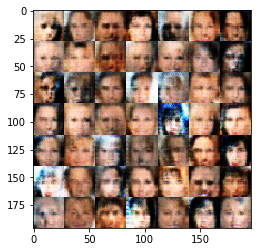

Epoch 1/1 Discriminator loss 1.5517 Generator loss 0.4414
Epoch 1/1 Discriminator loss 1.4294 Generator loss 0.5243
Epoch 1/1 Discriminator loss 1.2757 Generator loss 0.6811
Epoch 1/1 Discriminator loss 1.6192 Generator loss 0.3927
Epoch 1/1 Discriminator loss 1.5539 Generator loss 0.4219
Epoch 1/1 Discriminator loss 1.2241 Generator loss 1.0458
Epoch 1/1 Discriminator loss 1.4639 Generator loss 1.0216
Epoch 1/1 Discriminator loss 1.4139 Generator loss 1.0942
Epoch 1/1 Discriminator loss 1.5522 Generator loss 1.2073
Epoch 1/1 Discriminator loss 1.2367 Generator loss 1.0626


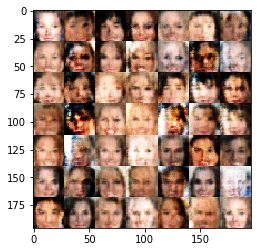

Epoch 1/1 Discriminator loss 1.4545 Generator loss 1.2495
Epoch 1/1 Discriminator loss 1.4304 Generator loss 1.2233
Epoch 1/1 Discriminator loss 1.4807 Generator loss 1.3321
Epoch 1/1 Discriminator loss 1.5069 Generator loss 1.2383
Epoch 1/1 Discriminator loss 1.3996 Generator loss 1.1223
Epoch 1/1 Discriminator loss 1.2541 Generator loss 0.9921
Epoch 1/1 Discriminator loss 1.4222 Generator loss 0.5817
Epoch 1/1 Discriminator loss 1.4999 Generator loss 0.4797
Epoch 1/1 Discriminator loss 1.5201 Generator loss 0.4578
Epoch 1/1 Discriminator loss 1.3344 Generator loss 0.6565


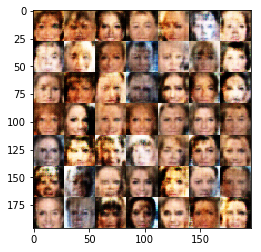

Epoch 1/1 Discriminator loss 1.6478 Generator loss 1.2274
Epoch 1/1 Discriminator loss 1.5640 Generator loss 1.3294
Epoch 1/1 Discriminator loss 1.2416 Generator loss 1.0684
Epoch 1/1 Discriminator loss 1.3676 Generator loss 1.0535
Epoch 1/1 Discriminator loss 1.5620 Generator loss 1.1675
Epoch 1/1 Discriminator loss 1.2856 Generator loss 0.6601
Epoch 1/1 Discriminator loss 1.5021 Generator loss 0.4779
Epoch 1/1 Discriminator loss 1.6080 Generator loss 0.3787
Epoch 1/1 Discriminator loss 1.4226 Generator loss 0.5036
Epoch 1/1 Discriminator loss 1.6209 Generator loss 0.3780


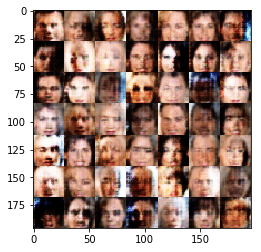

Epoch 1/1 Discriminator loss 1.4229 Generator loss 0.5041
Epoch 1/1 Discriminator loss 1.4024 Generator loss 0.5686
Epoch 1/1 Discriminator loss 1.3731 Generator loss 0.5796
Epoch 1/1 Discriminator loss 1.4001 Generator loss 1.3951
Epoch 1/1 Discriminator loss 1.2334 Generator loss 1.3007
Epoch 1/1 Discriminator loss 1.5932 Generator loss 1.3795
Epoch 1/1 Discriminator loss 1.7603 Generator loss 0.3191
Epoch 1/1 Discriminator loss 1.3926 Generator loss 0.5321
Epoch 1/1 Discriminator loss 1.3952 Generator loss 0.5098
Epoch 1/1 Discriminator loss 1.8198 Generator loss 0.2779


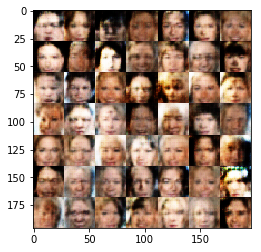

Epoch 1/1 Discriminator loss 1.3830 Generator loss 0.5658
Epoch 1/1 Discriminator loss 1.5457 Generator loss 0.3855
Epoch 1/1 Discriminator loss 1.3679 Generator loss 0.5308
Epoch 1/1 Discriminator loss 1.1706 Generator loss 0.6496
Epoch 1/1 Discriminator loss 1.4741 Generator loss 0.4989
Epoch 1/1 Discriminator loss 1.4552 Generator loss 0.4348
Epoch 1/1 Discriminator loss 1.5373 Generator loss 0.3956
Epoch 1/1 Discriminator loss 1.4763 Generator loss 0.5206
Epoch 1/1 Discriminator loss 1.2877 Generator loss 0.5741
Epoch 1/1 Discriminator loss 1.3374 Generator loss 0.6093


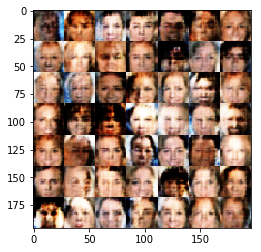

Epoch 1/1 Discriminator loss 1.5211 Generator loss 0.4753
Epoch 1/1 Discriminator loss 1.5002 Generator loss 0.4182
Epoch 1/1 Discriminator loss 1.3707 Generator loss 0.5306
Epoch 1/1 Discriminator loss 1.0901 Generator loss 0.8017
Epoch 1/1 Discriminator loss 1.5399 Generator loss 0.3825
Epoch 1/1 Discriminator loss 1.3592 Generator loss 0.5845
Epoch 1/1 Discriminator loss 0.6772 Generator loss 1.4621
Epoch 1/1 Discriminator loss 2.1823 Generator loss 0.1843
Epoch 1/1 Discriminator loss 1.6325 Generator loss 0.3783
Epoch 1/1 Discriminator loss 1.0581 Generator loss 0.8462


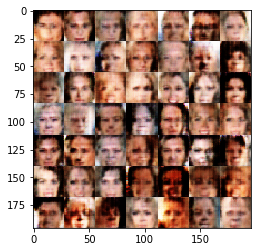

Epoch 1/1 Discriminator loss 2.0355 Generator loss 1.9650
Epoch 1/1 Discriminator loss 1.1887 Generator loss 1.8169
Epoch 1/1 Discriminator loss 1.3731 Generator loss 1.7452
Epoch 1/1 Discriminator loss 1.2437 Generator loss 0.9772
Epoch 1/1 Discriminator loss 1.1787 Generator loss 1.0651
Epoch 1/1 Discriminator loss 0.7994 Generator loss 1.0948
Epoch 1/1 Discriminator loss 0.4732 Generator loss 2.1466
Epoch 1/1 Discriminator loss 0.5186 Generator loss 1.9024
Epoch 1/1 Discriminator loss 1.2861 Generator loss 0.7458
Epoch 1/1 Discriminator loss 1.3535 Generator loss 0.5234


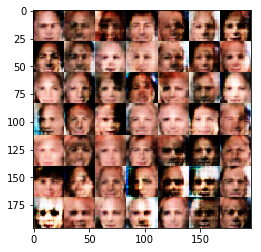

Epoch 1/1 Discriminator loss 1.4625 Generator loss 0.5568
Epoch 1/1 Discriminator loss 1.3832 Generator loss 0.6624
Epoch 1/1 Discriminator loss 1.4144 Generator loss 0.5685
Epoch 1/1 Discriminator loss 1.3632 Generator loss 0.6702
Epoch 1/1 Discriminator loss 1.3432 Generator loss 0.7141
Epoch 1/1 Discriminator loss 1.4494 Generator loss 1.4676
Epoch 1/1 Discriminator loss 1.3545 Generator loss 1.0772
Epoch 1/1 Discriminator loss 1.2916 Generator loss 1.2594
Epoch 1/1 Discriminator loss 1.2357 Generator loss 1.4444
Epoch 1/1 Discriminator loss 1.6199 Generator loss 1.9150


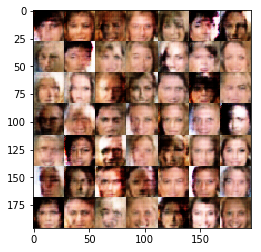

Epoch 1/1 Discriminator loss 0.8292 Generator loss 1.2349
Epoch 1/1 Discriminator loss 1.3669 Generator loss 1.0211
Epoch 1/1 Discriminator loss 1.2648 Generator loss 1.5795
Epoch 1/1 Discriminator loss 1.0914 Generator loss 0.9152
Epoch 1/1 Discriminator loss 0.6387 Generator loss 1.3836
Epoch 1/1 Discriminator loss 3.7673 Generator loss 0.0491
Epoch 1/1 Discriminator loss 1.2602 Generator loss 0.8262
Epoch 1/1 Discriminator loss 2.0717 Generator loss 2.5004
Epoch 1/1 Discriminator loss 0.6431 Generator loss 1.6949
Epoch 1/1 Discriminator loss 1.6448 Generator loss 1.7530


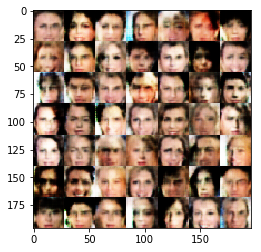

Epoch 1/1 Discriminator loss 1.3520 Generator loss 1.2187
Epoch 1/1 Discriminator loss 1.3862 Generator loss 1.6329
Epoch 1/1 Discriminator loss 1.2790 Generator loss 1.1512
Epoch 1/1 Discriminator loss 1.2006 Generator loss 0.5865
Epoch 1/1 Discriminator loss 1.6791 Generator loss 0.3947
Epoch 1/1 Discriminator loss 1.4081 Generator loss 0.6255
Epoch 1/1 Discriminator loss 1.2967 Generator loss 0.7669
Epoch 1/1 Discriminator loss 1.3144 Generator loss 0.9588
Epoch 1/1 Discriminator loss 1.5215 Generator loss 0.4558
Epoch 1/1 Discriminator loss 1.2980 Generator loss 0.6457


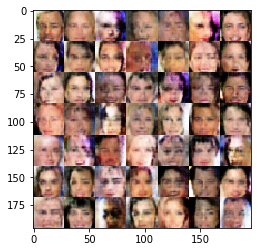

Epoch 1/1 Discriminator loss 0.8889 Generator loss 1.5085
Epoch 1/1 Discriminator loss 0.9064 Generator loss 0.8966
Epoch 1/1 Discriminator loss 1.3999 Generator loss 1.0537
Epoch 1/1 Discriminator loss 1.1218 Generator loss 0.7707
Epoch 1/1 Discriminator loss 1.5872 Generator loss 0.3822
Epoch 1/1 Discriminator loss 0.6046 Generator loss 1.6758
Epoch 1/1 Discriminator loss 0.4259 Generator loss 2.7285
Epoch 1/1 Discriminator loss 1.3120 Generator loss 0.6072
Epoch 1/1 Discriminator loss 1.4753 Generator loss 0.4902
Epoch 1/1 Discriminator loss 1.2494 Generator loss 0.7312


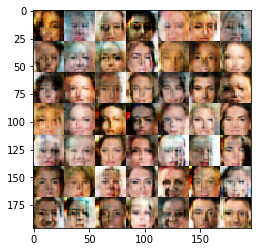

Epoch 1/1 Discriminator loss 1.4276 Generator loss 0.5787
Epoch 1/1 Discriminator loss 1.3144 Generator loss 0.8419
Epoch 1/1 Discriminator loss 1.2739 Generator loss 0.9325
Epoch 1/1 Discriminator loss 1.3534 Generator loss 0.7425
Epoch 1/1 Discriminator loss 1.2933 Generator loss 0.8559
Epoch 1/1 Discriminator loss 1.3021 Generator loss 1.0571
Epoch 1/1 Discriminator loss 1.3401 Generator loss 1.0469
Epoch 1/1 Discriminator loss 1.2810 Generator loss 1.0057
Epoch 1/1 Discriminator loss 1.4035 Generator loss 1.0723
Epoch 1/1 Discriminator loss 1.3281 Generator loss 1.2155


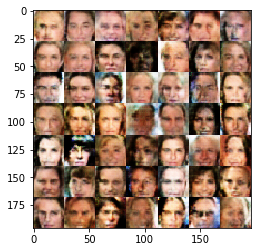

Epoch 1/1 Discriminator loss 1.3147 Generator loss 1.0732
Epoch 1/1 Discriminator loss 1.3533 Generator loss 0.8207
Epoch 1/1 Discriminator loss 1.5079 Generator loss 0.4630
Epoch 1/1 Discriminator loss 1.3357 Generator loss 0.6163
Epoch 1/1 Discriminator loss 1.5193 Generator loss 0.4475
Epoch 1/1 Discriminator loss 1.4747 Generator loss 0.4653
Epoch 1/1 Discriminator loss 1.3639 Generator loss 0.8382
Epoch 1/1 Discriminator loss 1.3185 Generator loss 0.8642
Epoch 1/1 Discriminator loss 1.4139 Generator loss 0.6553
Epoch 1/1 Discriminator loss 1.2821 Generator loss 0.7799


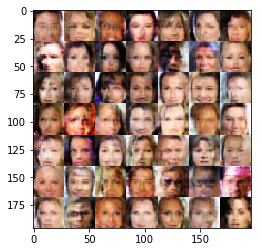

Epoch 1/1 Discriminator loss 1.4738 Generator loss 0.5014
Epoch 1/1 Discriminator loss 1.4154 Generator loss 0.7083
Epoch 1/1 Discriminator loss 1.4382 Generator loss 0.4846
Epoch 1/1 Discriminator loss 1.3392 Generator loss 1.0423
Epoch 1/1 Discriminator loss 1.4846 Generator loss 1.2598
Epoch 1/1 Discriminator loss 1.4058 Generator loss 1.0303
Epoch 1/1 Discriminator loss 1.2690 Generator loss 0.7976
Epoch 1/1 Discriminator loss 1.3466 Generator loss 0.9154
Epoch 1/1 Discriminator loss 1.6404 Generator loss 1.4327
Epoch 1/1 Discriminator loss 1.3430 Generator loss 0.8274


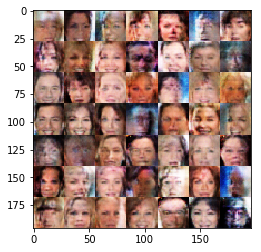

Epoch 1/1 Discriminator loss 1.5275 Generator loss 0.4459
Epoch 1/1 Discriminator loss 1.3454 Generator loss 0.6256
Epoch 1/1 Discriminator loss 1.3654 Generator loss 0.6929
Epoch 1/1 Discriminator loss 1.4124 Generator loss 0.6588
Epoch 1/1 Discriminator loss 1.5391 Generator loss 0.4317
Epoch 1/1 Discriminator loss 1.3293 Generator loss 0.8938
Epoch 1/1 Discriminator loss 1.3967 Generator loss 0.5375
Epoch 1/1 Discriminator loss 1.4217 Generator loss 0.5069
Epoch 1/1 Discriminator loss 1.4829 Generator loss 0.4614
Epoch 1/1 Discriminator loss 1.4312 Generator loss 0.5406


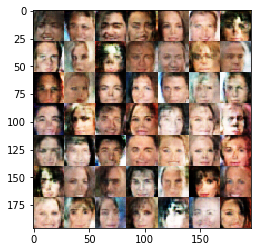

Epoch 1/1 Discriminator loss 1.3600 Generator loss 0.6096
Epoch 1/1 Discriminator loss 1.3690 Generator loss 0.7038


In [43]:
batch_size = 100
z_dim = 100
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.